AI POWERED TASK MANAGEMENT

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import string

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
# For workload balancing (conceptual, will be implemented heuristically initially)
# from collections import defaultdict


In [28]:
# Download NLTK assets (only run once). Comment the code after running
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\priya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\priya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\priya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\priya\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [29]:
df = pd.read_csv("synthetic_task_dataset.csv",index_col=0)
df.head()

,task_description,creation_date,due_date,priority,task_category,assigned_to,estimated_effort_hours,user_preferred_categories,user_past_completion_time_avg_hours,user_current_workload
task_id,,,,,,,,,,
1,Schedule interviews for Software Engineer.,2025-04-22,2025-04-28,High,HR,Noah,12,"HR, Research",9.400249,3
2,Plan team-building event for Q4.,2025-01-25,2025-01-29,High,HR,Noah,4,"HR, Research",9.400249,3
3,Optimize encryption for performance.,2025-04-05,2025-04-24,Medium,Development,Oscar,7,Development,5.266582,8
4,Update knowledge base article on troubleshooti...,2025-03-10,2025-03-22,Low,Support,Felix,7,Development,6.326326,5
5,Update employee records for address change.,2025-03-25,2025-03-30,Medium,HR,Emily,8,"HR, Marketing",6.308737,5


EDA

In [30]:
df.columns

Index(['task_description', 'creation_date', 'due_date', 'priority',
       'task_category', 'assigned_to', 'estimated_effort_hours',
       'user_preferred_categories', 'user_past_completion_time_avg_hours',
       'user_current_workload'],
      dtype='object')

In [31]:
df.drop(columns=['user_past_completion_time_avg_hours'],inplace = True)

In [32]:
df.dtypes

task_description             object
creation_date                object
due_date                     object
priority                     object
task_category                object
assigned_to                  object
estimated_effort_hours        int64
user_preferred_categories    object
user_current_workload         int64
dtype: object

In [33]:
df['creation_date'] = pd.to_datetime(df['creation_date'])
df['due_date'] = pd.to_datetime(df['due_date'])

In [34]:
df.isnull().sum()

task_description               0
creation_date                  0
due_date                     592
priority                       0
task_category                  0
assigned_to                    0
estimated_effort_hours         0
user_preferred_categories      0
user_current_workload          0
dtype: int64

In [35]:
# Create deadline-based features
df['days_until_due'] = (df['due_date'] - df['creation_date']).dt.days
df['days_until_due'] = df['days_until_due'].fillna(-1)  # -1 = No due date

# Add binary indicator
df['has_due_date'] = df['due_date'].notnull().astype(int)

In [36]:
df.head()

,task_description,creation_date,due_date,priority,task_category,assigned_to,estimated_effort_hours,user_preferred_categories,user_current_workload,days_until_due,has_due_date
task_id,,,,,,,,,,,
1,Schedule interviews for Software Engineer.,2025-04-22,2025-04-28,High,HR,Noah,12,"HR, Research",3,6.0,1
2,Plan team-building event for Q4.,2025-01-25,2025-01-29,High,HR,Noah,4,"HR, Research",3,4.0,1
3,Optimize encryption for performance.,2025-04-05,2025-04-24,Medium,Development,Oscar,7,Development,8,19.0,1
4,Update knowledge base article on troubleshooti...,2025-03-10,2025-03-22,Low,Support,Felix,7,Development,5,12.0,1
5,Update employee records for address change.,2025-03-25,2025-03-30,Medium,HR,Emily,8,"HR, Marketing",5,5.0,1


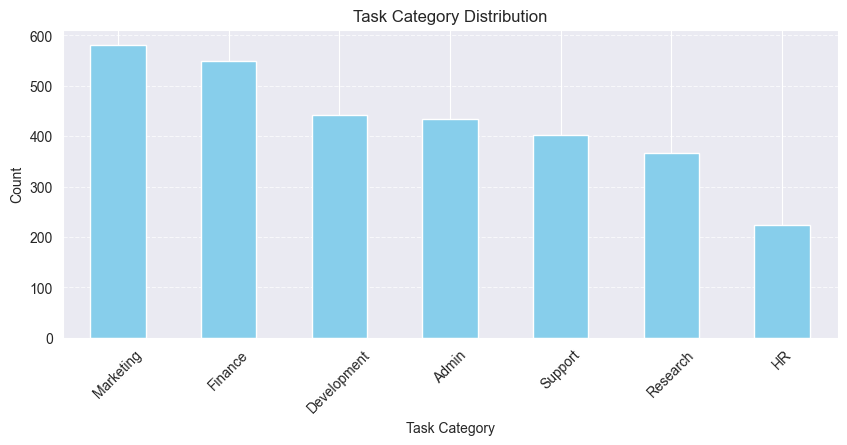

In [37]:
# Task Category Count Plot
df['task_category'].value_counts().plot(kind='bar', figsize=(10, 4), color='skyblue', title='Task Category Distribution')
plt.xlabel('Task Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

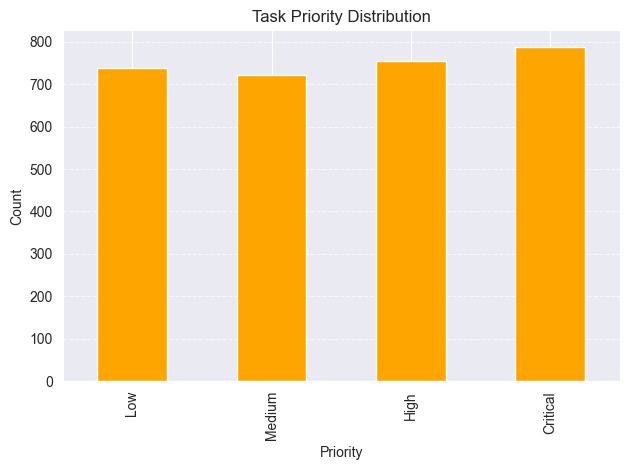

In [38]:

# Priority Count Plot
df['priority'].value_counts().loc[['Low', 'Medium', 'High', 'Critical']].plot(kind='bar', color='orange', title='Task Priority Distribution')
plt.xlabel('Priority')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

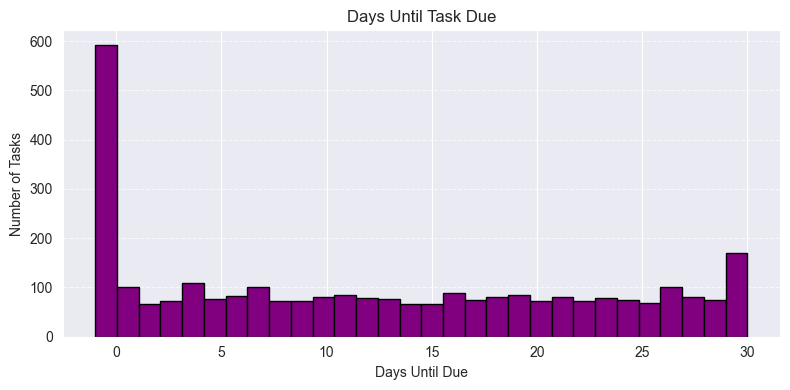

In [39]:
# Days Until Due Histogram
plt.figure(figsize=(8, 4))
plt.hist(df['days_until_due'], bins=30, color='purple', edgecolor='black')
plt.title('Days Until Task Due')
plt.xlabel('Days Until Due')
plt.ylabel('Number of Tasks')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

NLP Preprocessing

In [40]:
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text):
    # Lowercase
    text = text.lower()
    
    # Remove punctuation & numbers
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords and apply stemming
    cleaned = [stemmer.stem(word) for word in tokens if word not in stop_words]
    
    return " ".join(cleaned)



In [41]:
df['clean_description'] = df['task_description'].apply(preprocess_text)
df[['task_description', 'clean_description']].head()


,task_description,clean_description
task_id,,
1,Schedule interviews for Software Engineer.,schedul interview softwar engin
2,Plan team-building event for Q4.,plan teambuild event q
3,Optimize encryption for performance.,optim encrypt perform
4,Update knowledge base article on troubleshooti...,updat knowledg base articl troubleshoot guid
5,Update employee records for address change.,updat employe record address chang


In [42]:
# week - 2
if 'df' not in locals() or not all(col in df.columns for col in ['clean_description', 'days_until_due', 'has_due_date']):
    print("DataFrame 'df' not found or not fully preprocessed. Loading and performing essential preprocessing.")
    df = pd.read_csv("synthetic_task_dataset.csv", index_col=0)
    df.drop(columns=['user_past_completion_time_avg_hours'], inplace=True)
    df['creation_date'] = pd.to_datetime(df['creation_date'])
    df['due_date'] = pd.to_datetime(df['due_date'])
    df['days_until_due'] = (df['due_date'] - df['creation_date']).dt.days
    df['days_until_due'] = df['days_until_due'].fillna(-1)
    df['has_due_date'] = df['due_date'].notnull().astype(int)

    stop_words = set(stopwords.words('english'))
    stemmer = PorterStemmer()

    def preprocess_text(text):
        text = text.lower()
        text = re.sub(r'\d+', '', text)
        text = text.translate(str.maketrans('', '', string.punctuation))
        tokens = word_tokenize(text)
        cleaned = [stemmer.stem(word) for word in tokens if word not in stop_words]
        return " ".join(cleaned)

    df['clean_description'] = df['task_description'].apply(preprocess_text)
    print("Essential preprocessing from Week 1 completed.")
else:
    print("DataFrame 'df' already loaded and preprocessed from Week 1.")

# Display head to confirm
df.head()

DataFrame 'df' already loaded and preprocessed from Week 1.


,task_description,creation_date,due_date,priority,task_category,assigned_to,estimated_effort_hours,user_preferred_categories,user_current_workload,days_until_due,has_due_date,clean_description
task_id,,,,,,,,,,,,
1,Schedule interviews for Software Engineer.,2025-04-22,2025-04-28,High,HR,Noah,12,"HR, Research",3,6.0,1,schedul interview softwar engin
2,Plan team-building event for Q4.,2025-01-25,2025-01-29,High,HR,Noah,4,"HR, Research",3,4.0,1,plan teambuild event q
3,Optimize encryption for performance.,2025-04-05,2025-04-24,Medium,Development,Oscar,7,Development,8,19.0,1,optim encrypt perform
4,Update knowledge base article on troubleshooti...,2025-03-10,2025-03-22,Low,Support,Felix,7,Development,5,12.0,1,updat knowledg base articl troubleshoot guid
5,Update employee records for address change.,2025-03-25,2025-03-30,Medium,HR,Emily,8,"HR, Marketing",5,5.0,1,updat employe record address chang


In [43]:
# Cell 3: Prepare Target Variable and Features 🎯

# Map priority to numerical labels
priority_mapping = {'Low': 0, 'Medium': 1, 'High': 2, 'Critical': 3}
df['priority_encoded'] = df['priority'].map(priority_mapping)

# Drop rows where priority_encoded might be NaN if original priority had unexpected values
df.dropna(subset=['priority_encoded'], inplace=True)
df['priority_encoded'] = df['priority_encoded'].astype(int)

# --- FIX FOR NEGATIVE VALUES IN MultinomialNB ---
# Replace -1 in 'days_until_due' with 0 or another non-negative value for MultinomialNB
# MultinomialNB requires non-negative features.
df['days_until_due_non_negative'] = df['days_until_due'].apply(lambda x: max(0, x))

# Define features (X) and target (y)
X_text = df['clean_description']
# Use the non-negative version of days_until_due
X_numerical = df[['days_until_due_non_negative', 'has_due_date']]
y = df['priority_encoded']

print("Target variable and features prepared.")
print(f"Unique priority labels: {df['priority'].unique()}")
print(f"Encoded priority labels: {df['priority_encoded'].unique()}")

Target variable and features prepared.
Unique priority labels: ['High' 'Medium' 'Low' 'Critical']
Encoded priority labels: [2 1 0 3]


In [44]:
#Feature Extraction using TF-IDF

print("--- Feature Extraction: TF-IDF ---")
vectorizer = TfidfVectorizer(max_features=1000) # Limit features to avoid too large a sparse matrix
X_tfidf = vectorizer.fit_transform(X_text)

# Convert TF-IDF sparse matrix to DataFrame for concatenation
X_tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
# Ensure indices align for proper concatenation
X_tfidf_df.index = X_numerical.index
X_combined = pd.concat([X_tfidf_df, X_numerical], axis=1)

print(f"TF-IDF features shape: {X_tfidf.shape}")
print(f"Combined features shape: {X_combined.shape}")
print("TF-IDF vectorization complete and combined with numerical features.")

--- Feature Extraction: TF-IDF ---
TF-IDF features shape: (3000, 171)
Combined features shape: (3000, 173)
TF-IDF vectorization complete and combined with numerical features.


In [45]:
#Train-Test Split

print("--- Splitting Data into Training and Testing Sets ---")
# Stratify by 'y' to maintain class distribution across splits
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")
print("Data split into training and testing sets.")

--- Splitting Data into Training and Testing Sets ---
Training set size: 2400 samples
Testing set size: 600 samples
Data split into training and testing sets.


In [46]:
#Implement and Evaluate Naive Bayes Classifier

print("--- Training Naive Bayes Classifier ---")
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
print("Naive Bayes model trained.")

print("\n--- Evaluating Naive Bayes Classifier ---")
y_pred_nb = nb_model.predict(X_test)

print("Naive Bayes Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_nb):.4f}")
print(f"Precision (macro): {precision_score(y_test, y_pred_nb, average='macro', zero_division=0):.4f}")
print(f"Recall (macro): {recall_score(y_test, y_pred_nb, average='macro', zero_division=0):.4f}")
print(f"F1-Score (macro): {f1_score(y_test, y_pred_nb, average='macro', zero_division=0):.4f}")
# Use a custom target_names list for the classification report if priority_mapping.keys() isn't directly ordered
target_names_list = sorted(priority_mapping, key=priority_mapping.get)
print("\nClassification Report (Naive Bayes):\n", classification_report(y_test, y_pred_nb, target_names=target_names_list, zero_division=0))


--- Training Naive Bayes Classifier ---
Naive Bayes model trained.

--- Evaluating Naive Bayes Classifier ---
Naive Bayes Metrics:
Accuracy: 0.2483
Precision (macro): 0.2455
Recall (macro): 0.2472
F1-Score (macro): 0.2420

Classification Report (Naive Bayes):
               precision    recall  f1-score   support

         Low       0.26      0.33      0.30       147
      Medium       0.24      0.16      0.19       144
        High       0.23      0.19      0.20       151
    Critical       0.25      0.31      0.28       158

    accuracy                           0.25       600
   macro avg       0.25      0.25      0.24       600
weighted avg       0.25      0.25      0.24       600



In [47]:
#Implement and Evaluate SVM Classifier

print("--- Training Support Vector Machine (SVM) Classifier ---")
svm_model = SVC(kernel='linear', random_state=42) # 'linear' kernel often works well with TF-IDF
svm_model.fit(X_train, y_train)
print("SVM model trained.")

print("\n--- Evaluating SVM Classifier ---")
y_pred_svm = svm_model.predict(X_test)

print("SVM Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print(f"Precision (macro): {precision_score(y_test, y_pred_svm, average='macro', zero_division=0):.4f}")
print(f"Recall (macro): {recall_score(y_test, y_pred_svm, average='macro', zero_division=0):.4f}")
print(f"F1-Score (macro): {f1_score(y_test, y_pred_svm, average='macro', zero_division=0):.4f}")
# Use the same target_names list for consistency
print("\nClassification Report (SVM):\n", classification_report(y_test, y_pred_svm, target_names=target_names_list, zero_division=0))

--- Training Support Vector Machine (SVM) Classifier ---
SVM model trained.

--- Evaluating SVM Classifier ---
SVM Metrics:
Accuracy: 0.2500
Precision (macro): 0.2481
Recall (macro): 0.2494
F1-Score (macro): 0.2470

Classification Report (SVM):
               precision    recall  f1-score   support

         Low       0.27      0.31      0.29       147
      Medium       0.23      0.22      0.22       144
        High       0.23      0.18      0.20       151
    Critical       0.25      0.30      0.27       158

    accuracy                           0.25       600
   macro avg       0.25      0.25      0.25       600
weighted avg       0.25      0.25      0.25       600



In [48]:
#Word Embeddings (Conceptual Placeholder)

print("\n--- Feature Extraction: Word Embeddings (Conceptual Placeholder) ---")
print("Implementing Word2Vec or BERT requires additional steps:")
print("1. **Installation:** `pip install gensim` (for Word2Vec) or `pip install transformers` (for BERT).")
print("2. **Model Loading/Training:** Download pre-trained models (e.g., from `gensim.downloader` or Hugging Face `transformers`).")
print("3. **Embedding Generation:** Convert 'clean_description' text into numerical vector embeddings using the loaded model.")
print("   - For Word2Vec: Average word vectors in a sentence.")
print("   - For BERT: Extract [CLS] token embeddings or mean-pool token embeddings.")
print("4. **Integration:** Replace or combine these embeddings with your existing numerical features before training classifiers.")
print("\nThis is a more advanced step for potentially higher model performance.")


--- Feature Extraction: Word Embeddings (Conceptual Placeholder) ---
Implementing Word2Vec or BERT requires additional steps:
1. **Installation:** `pip install gensim` (for Word2Vec) or `pip install transformers` (for BERT).
2. **Model Loading/Training:** Download pre-trained models (e.g., from `gensim.downloader` or Hugging Face `transformers`).
3. **Embedding Generation:** Convert 'clean_description' text into numerical vector embeddings using the loaded model.
   - For Word2Vec: Average word vectors in a sentence.
   - For BERT: Extract [CLS] token embeddings or mean-pool token embeddings.
4. **Integration:** Replace or combine these embeddings with your existing numerical features before training classifiers.

This is a more advanced step for potentially higher model performance.


Week 3

In [5]:
# Check if df from Week 1 is already in memory and preprocessed
# If not, load and perform essential preprocessing from Week 1 for a runnable script

if 'df' not in locals() or not all(col in df.columns for col in ['clean_description', 'days_until_due', 'has_due_date']):
    print("DataFrame 'df' not found or not fully preprocessed. Loading and performing essential preprocessing.")
    df = pd.read_csv("synthetic_task_dataset.csv", index_col=0)
    df.drop(columns=['user_past_completion_time_avg_hours'], inplace=True)
    df['creation_date'] = pd.to_datetime(df['creation_date'])
    df['due_date'] = pd.to_datetime(df['due_date'])
    df['days_until_due'] = (df['due_date'] - df['creation_date']).dt.days
    df['days_until_due'] = df['days_until_due'].fillna(-1)
    df['has_due_date'] = df['due_date'].notnull().astype(int)

    # --- Re-including essential NLP preprocessing from Week 1 ---
    import re
    import string
    from nltk.corpus import stopwords
    from nltk.stem import PorterStemmer
    from nltk.tokenize import word_tokenize

    # Ensure NLTK assets are downloaded (run once, then comment out)
    # import nltk
    # nltk.download('stopwords')
    # nltk.download('punkt')
    # nltk.download('punkt_tab')
    # import nltk
    # nltk.download('wordnet')

    stop_words = set(stopwords.words('english'))
    stemmer = PorterStemmer()

    def preprocess_text(text):
        text = text.lower()
        text = re.sub(r'\d+', '', text)
        text = text.translate(str.maketrans('', '', string.punctuation))
        tokens = word_tokenize(text)
        cleaned = [stemmer.stem(word) for word in tokens if word not in stop_words]
        return " ".join(cleaned)

    df['clean_description'] = df['task_description'].apply(preprocess_text)
    print("Essential preprocessing from Week 1 completed.")
else:
    print("DataFrame 'df' already loaded and preprocessed from Week 1.")

# Map priority to numerical labels (re-run to be safe or if kernel restarted)
priority_mapping = {'Low': 0, 'Medium': 1, 'High': 2, 'Critical': 3}
df['priority_encoded'] = df['priority'].map(priority_mapping)
df.dropna(subset=['priority_encoded'], inplace=True)
df['priority_encoded'] = df['priority_encoded'].astype(int)

# --- Ensure non-negative feature for compatibility with Naive Bayes if needed later ---
df['days_until_due_non_negative'] = df['days_until_due'].apply(lambda x: max(0, x))

# Display head to confirm
df.head()

DataFrame 'df' not found or not fully preprocessed. Loading and performing essential preprocessing.
Essential preprocessing from Week 1 completed.


,task_description,creation_date,due_date,priority,task_category,assigned_to,estimated_effort_hours,user_preferred_categories,user_current_workload,days_until_due,has_due_date,clean_description,priority_encoded,days_until_due_non_negative
task_id,,,,,,,,,,,,,,
1,Schedule interviews for Software Engineer.,2025-04-22,2025-04-28,High,HR,Noah,12,"HR, Research",3,6.0,1,schedul interview softwar engin,2,6.0
2,Plan team-building event for Q4.,2025-01-25,2025-01-29,High,HR,Noah,4,"HR, Research",3,4.0,1,plan teambuild event q,2,4.0
3,Optimize encryption for performance.,2025-04-05,2025-04-24,Medium,Development,Oscar,7,Development,8,19.0,1,optim encrypt perform,1,19.0
4,Update knowledge base article on troubleshooti...,2025-03-10,2025-03-22,Low,Support,Felix,7,Development,5,12.0,1,updat knowledg base articl troubleshoot guid,0,12.0
5,Update employee records for address change.,2025-03-25,2025-03-30,Medium,HR,Emily,8,"HR, Marketing",5,5.0,1,updat employe record address chang,1,5.0


Feature Extraction (TF-IDF) and Train-Test Split

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

print("--- Feature Extraction: TF-IDF ---")
vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = vectorizer.fit_transform(df['clean_description'])

X_tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
X_tfidf_df.index = df.index # Align indices with original df

# Combine TF-IDF features with numerical features
X_numerical = df[['days_until_due_non_negative', 'has_due_date']]
X_combined = pd.concat([X_tfidf_df, X_numerical], axis=1)

y = df['priority_encoded']

print(f"Combined features shape: {X_combined.shape}")
print(f"Target variable shape: {y.shape}")

print("\n--- Splitting Data into Training and Testing Sets ---")
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")
print("Data split into training and testing sets.")

--- Feature Extraction: TF-IDF ---
Combined features shape: (3000, 173)
Target variable shape: (3000,)

--- Splitting Data into Training and Testing Sets ---
Training set size: 2400 samples
Testing set size: 600 samples
Data split into training and testing sets.


Implement Priority Prediction Model using Random Forest

In [7]:
print("\n--- Training Random Forest Classifier ---")
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
print("Random Forest model trained.")

print("\n--- Evaluating Random Forest Classifier ---")
y_pred_rf = rf_model.predict(X_test)

print("Random Forest Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision (macro): {precision_score(y_test, y_pred_rf, average='macro', zero_division=0):.4f}")
print(f"Recall (macro): {recall_score(y_test, y_pred_rf, average='macro', zero_division=0):.4f}")
print(f"F1-Score (macro): {f1_score(y_test, y_pred_rf, average='macro', zero_division=0):.4f}")
target_names_list = sorted(priority_mapping, key=priority_mapping.get) # Ensure correct order
print("\nClassification Report (Random Forest):\n", classification_report(y_test, y_pred_rf, target_names=target_names_list, zero_division=0))


--- Training Random Forest Classifier ---
Random Forest model trained.

--- Evaluating Random Forest Classifier ---
Random Forest Metrics:
Accuracy: 0.2450
Precision (macro): 0.2436
Recall (macro): 0.2446
F1-Score (macro): 0.2438

Classification Report (Random Forest):
               precision    recall  f1-score   support

         Low       0.21      0.21      0.21       147
      Medium       0.25      0.28      0.26       144
        High       0.22      0.20      0.21       151
    Critical       0.29      0.29      0.29       158

    accuracy                           0.24       600
   macro avg       0.24      0.24      0.24       600
weighted avg       0.24      0.24      0.24       600



Implement Priority Prediction Model using XGBoost

In [8]:
print("\n--- Training XGBoost Classifier ---")
# XGBoost requires numerical labels for multiclass classification, which we already have.
# Use 'objective': 'multi:softmax' for multi-class classification
# num_class is the number of unique classes in your target variable
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(priority_mapping),
                              eval_metric='mlogloss', use_label_encoder=False, random_state=42)
xgb_model.fit(X_train, y_train)
print("XGBoost model trained.")

print("\n--- Evaluating XGBoost Classifier ---")
y_pred_xgb = xgb_model.predict(X_test)

print("XGBoost Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"Precision (macro): {precision_score(y_test, y_pred_xgb, average='macro', zero_division=0):.4f}")
print(f"Recall (macro): {recall_score(y_test, y_pred_xgb, average='macro', zero_division=0):.4f}")
print(f"F1-Score (macro): {f1_score(y_test, y_pred_xgb, average='macro', zero_division=0):.4f}")
print("\nClassification Report (XGBoost):\n", classification_report(y_test, y_pred_xgb, target_names=target_names_list, zero_division=0))


--- Training XGBoost Classifier ---


C:\Users\priya\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:21:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost model trained.

--- Evaluating XGBoost Classifier ---
XGBoost Metrics:
Accuracy: 0.2350
Precision (macro): 0.2341
Recall (macro): 0.2341
F1-Score (macro): 0.2337

Classification Report (XGBoost):
               precision    recall  f1-score   support

         Low       0.21      0.20      0.21       147
      Medium       0.24      0.22      0.23       144
        High       0.23      0.23      0.23       151
    Critical       0.25      0.28      0.27       158

    accuracy                           0.23       600
   macro avg       0.23      0.23      0.23       600
weighted avg       0.23      0.23      0.23       600



Apply GridSearchCV for Hyperparameter Tuning (Random Forest Example)

In [9]:
print("\n--- Hyperparameter Tuning: GridSearchCV for Random Forest ---")

# Define the parameter grid to search
# Start with a smaller grid to save time, then expand if needed
param_grid_rf = {
    'n_estimators': [100, 200], # Number of trees in the forest
    'max_depth': [10, 20, None], # Maximum depth of the tree
    'min_samples_leaf': [1, 2], # Minimum number of samples required to be at a leaf node
    'criterion': ['gini', 'entropy'] # Function to measure the quality of a split
}

# Initialize GridSearchCV
# cv=3 for faster execution, use higher (e.g., 5) for more robust evaluation
grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                              param_grid=param_grid_rf,
                              cv=3, # Number of folds for cross-validation
                              n_jobs=-1, # Use all available CPU cores
                              verbose=2, # Verbosity level
                              scoring='f1_macro') # Metric to optimize

# Fit GridSearchCV to the training data
print("Running GridSearchCV for Random Forest... This might take a while.")
grid_search_rf.fit(X_train, y_train)

print("\n--- GridSearchCV Results for Random Forest ---")
print(f"Best parameters found: {grid_search_rf.best_params_}")
print(f"Best F1-macro score: {grid_search_rf.best_score_:.4f}")

# Evaluate the best Random Forest model on the test set
best_rf_model = grid_search_rf.best_estimator_
y_pred_best_rf = best_rf_model.predict(X_test)

print("\nEvaluating Best Random Forest Model (from GridSearchCV) on Test Set:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_best_rf):.4f}")
print(f"Precision (macro): {precision_score(y_test, y_pred_best_rf, average='macro', zero_division=0):.4f}")
print(f"Recall (macro): {recall_score(y_test, y_pred_best_rf, average='macro', zero_division=0):.4f}")
print(f"F1-Score (macro): {f1_score(y_test, y_pred_best_rf, average='macro', zero_division=0):.4f}")
print("\nClassification Report (Best Random Forest):\n", classification_report(y_test, y_pred_best_rf, target_names=target_names_list, zero_division=0))


--- Hyperparameter Tuning: GridSearchCV for Random Forest ---
Running GridSearchCV for Random Forest... This might take a while.
Fitting 3 folds for each of 24 candidates, totalling 72 fits

--- GridSearchCV Results for Random Forest ---
Best parameters found: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 100}
Best F1-macro score: 0.2547

Evaluating Best Random Forest Model (from GridSearchCV) on Test Set:
Accuracy: 0.2450
Precision (macro): 0.2434
Recall (macro): 0.2444
F1-Score (macro): 0.2437

Classification Report (Best Random Forest):
               precision    recall  f1-score   support

         Low       0.22      0.21      0.21       147
      Medium       0.24      0.26      0.25       144
        High       0.22      0.21      0.21       151
    Critical       0.29      0.30      0.29       158

    accuracy                           0.24       600
   macro avg       0.24      0.24      0.24       600
weighted avg       0.24      0.24  

Workload Balancing Logic (Heuristic Approach)

In [10]:
print("\n--- Workload Balancing Logic (Heuristic Approach) ---")

# --- SIMULATE USER DATA (You would replace this with actual user data) ---
# In a real scenario, this would come from a database or API
users = {
    'user_A': {'workload': 5, 'skills': ['development', 'design']}, # workload in hours/tasks
    'user_B': {'workload': 2, 'skills': ['development']},
    'user_C': {'workload': 8, 'skills': ['design', 'testing']},
    'user_D': {'workload': 3, 'skills': ['testing']}
}

# Function to get the current workload of a user
def get_user_workload(user_id):
    return users.get(user_id, {}).get('workload', float('inf')) # Return inf if user not found

# Simple heuristic: find the user with the lowest current workload
def assign_task_heuristically(predicted_priority, task_description, users_data):
    # For simplicity, let's just find the user with the minimum current workload
    # In a real system, you might also consider skills, availability, etc.
    if not users_data:
        return None, "No users available"

    min_workload = float('inf')
    assigned_user = None

    for user_id, user_info in users_data.items():
        if user_info['workload'] < min_workload:
            min_workload = user_info['workload']
            assigned_user = user_id

    if assigned_user:
        # Simulate assigning the task by increasing workload
        users_data[assigned_user]['workload'] += 1 # Increment by 1 task or estimated effort
    return assigned_user, f"Assigned to {assigned_user} with predicted priority {predicted_priority}"

# --- DEMONSTRATION OF WORKLOAD BALANCING ---
print("\nDemonstrating Task Assignment based on Heuristic Workload Balancing:")
sample_tasks = df[['task_description', 'clean_description', 'priority']].head(5).copy()
sample_tasks['predicted_priority'] = best_rf_model.predict(X_combined.loc[sample_tasks.index]) # Use best model to predict
sample_tasks['predicted_priority_label'] = sample_tasks['predicted_priority'].map({v: k for k, v in priority_mapping.items()})


print("\nInitial User Workloads:")
for user, info in users.items():
    print(f"  {user}: {info['workload']} tasks")

print("\nAssigning Sample Tasks:")
for index, row in sample_tasks.iterrows():
    # Convert numerical prediction back to label for display
    predicted_priority_label = row['predicted_priority_label']
    assigned_user, message = assign_task_heuristically(predicted_priority_label, row['task_description'], users)
    print(f"Task: '{row['task_description'][:50]}...' (Predicted Priority: {predicted_priority_label}) -> {message}")

print("\nUpdated User Workloads:")
for user, info in users.items():
    print(f"  {user}: {info['workload']} tasks")

print("\n--- Workload Balancing: ML Approach (Conceptual) ---")
print("For an ML-based workload balancing, you would typically need a dataset that includes:")
print("1. Task features (like the ones you already have).")
print("2. User features (skills, availability, historical performance, current workload).")
print("3. Target variable: Which user completed which task, or task completion time for specific users.")
print("This would involve training a regression model to predict completion time for each user, or a classification model to recommend the best user based on predicted workload impact.")
print("This is a more complex task requiring a different kind of labeled dataset.")


--- Workload Balancing Logic (Heuristic Approach) ---

Demonstrating Task Assignment based on Heuristic Workload Balancing:

Initial User Workloads:
  user_A: 5 tasks
  user_B: 2 tasks
  user_C: 8 tasks
  user_D: 3 tasks

Assigning Sample Tasks:
Task: 'Schedule interviews for Software Engineer....' (Predicted Priority: High) -> Assigned to user_B with predicted priority High
Task: 'Plan team-building event for Q4....' (Predicted Priority: High) -> Assigned to user_B with predicted priority High
Task: 'Optimize encryption for performance....' (Predicted Priority: Medium) -> Assigned to user_D with predicted priority Medium
Task: 'Update knowledge base article on troubleshooting g...' (Predicted Priority: Medium) -> Assigned to user_B with predicted priority Medium
Task: 'Update employee records for address change....' (Predicted Priority: Medium) -> Assigned to user_D with predicted priority Medium

Updated User Workloads:
  user_A: 5 tasks
  user_B: 5 tasks
  user_C: 8 tasks
  user_D: